<a href="https://colab.research.google.com/github/Rosvend/Passenger-flow-prediction-LSTM/blob/main/LSTM_Metro_passenger_flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from ipywidgets import interact, interact_manual

In [4]:
print('Descargando archivos...')
!curl -L "https://drive.google.com/uc?id=1Vk3kISIRnWhpF55VAlsXiaBC7-2VS7mp&export=download" -o Afluencia2024.xlsx
!curl -L "https://drive.google.com/uc?id=1rawKGyqGLCjhYsE1oePv499lQdawN3zX&export=download" -o Afluencia2023.xlsx
!curl -L "https://drive.google.com/uc?id=11VeQzlInoljZKKil7kPcWjwvESCZbMSv&export=download" -o Afluencia2022.xlsx
!curl -L "https://drive.google.com/uc?id=1zWP6FHA6aTJJ58xy119k5tAQRxI3DEIF&export=download" -o Afluencia2021.xlsx
!curl -L "https://drive.google.com/uc?id=1klQ3qzRFX2-jpkc4Nh8wLIo6weFKQ6Pa&export=download" -o Afluencia2020.xlsx
!curl -L "https://drive.google.com/uc?id=1PsQvhT1bt6-xr5vG1Xi95aHBg2anYI51&export=download" -o Afluencia2019.xlsx

Descargando archivos...
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 60500  100 60500    0     0  66578      0 --:--:-- --:--:-- --:--:-- 81426
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  659k  100  659k    0     0   513k      0  0:00:01  0:00:01 --:--:--  662k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  648k  100  648k    0     0   473k      0  0:00:01  0:00:01 --:--:-- 8214k
  % Total    % Received % Xf

In [5]:
df2019 = pd.read_excel('/content/Afluencia2019.xlsx',engine='openpyxl')
df2020 = pd.read_excel('/content/Afluencia2020.xlsx',engine='openpyxl')
df2021 = pd.read_excel('/content/Afluencia2021.xlsx',engine='openpyxl')
df2022 = pd.read_excel('/content/Afluencia2022.xlsx',engine='openpyxl')
df2023 = pd.read_excel('/content/Afluencia2023.xlsx',engine='openpyxl')
df2024 = pd.read_excel('/content/Afluencia2024.xlsx',engine='openpyxl')
df2023.head(13) #Imprimos las 12 lineas del metro

,Día,Línea de Servicio,Hora de operación,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22
0,NaN,NaN,04:00:00,05:00:00,06:00:00,07:00:00,08:00:00,09:00:00,10:00:00,11:00:00,...,15:00:00,16:00:00,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00,Total general (Número de pasajeros)
1,01/01/2023,LÍNEA 1,192,811,896,716,673,922,1023,1208,...,1629,1985,2361,2694,2303,1839,1478,236,NaN,25483
2,01/01/2023,LÍNEA 2,11,123,116,95,102,144,147,189,...,191,255,280,317,252,164,111,7,NaN,3210
3,01/01/2023,LÍNEA A,1328,5104,5701,4309,4054,4852,5880,7629,...,10999,13027,15965,19123,15663,12918,9509,819,NaN,166047
4,01/01/2024,LÍNEA B,221,701,750,655,628,863,1085,1228,...,1930,2247,2498,2648,2029,1472,1087,151,NaN,25106
5,01/01/2023,LÍNEA H,NaN,NaN,NaN,NaN,NaN,56,62,49,...,55,128,99,109,68,46,27,1,NaN,970
6,01/01/2023,LÍNEA J,NaN,NaN,NaN,NaN,NaN,470,410,490,...,688,710,857,933,651,311,146,3,NaN,7209
7,01/01/2023,LÍNEA K,NaN,NaN,NaN,NaN,350,555,630,745,...,1432,1515,1788,1562,1110,766,329,4,NaN,13664
8,01/01/2023,LÍNEA L,NaN,NaN,NaN,NaN,11,61,158,364,...,617,531,428,NaN,NaN,NaN,NaN,NaN,NaN,4113
9,01/01/2023,LÍNEA M,NaN,NaN,NaN,NaN,1,156,123,176,...,229,332,319,411,408,260,240,92,NaN,3425


In [6]:
df2023.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4304 entries, 0 to 4303
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Día                4303 non-null   object
 1   Línea de Servicio  4303 non-null   object
 2   Hora de operación  3639 non-null   object
 3   Unnamed: 3         3644 non-null   object
 4   Unnamed: 4         3648 non-null   object
 5   Unnamed: 5         3647 non-null   object
 6   Unnamed: 6         4093 non-null   object
 7   Unnamed: 7         4291 non-null   object
 8   Unnamed: 8         4290 non-null   object
 9   Unnamed: 9         4290 non-null   object
 10  Unnamed: 10        4294 non-null   object
 11  Unnamed: 11        4295 non-null   object
 12  Unnamed: 12        4296 non-null   object
 13  Unnamed: 13        4291 non-null   object
 14  Unnamed: 14        4292 non-null   object
 15  Unnamed: 15        4297 non-null   object
 16  Unnamed: 16        4056 non-null   object


In [7]:
#Cambiamos los nombres de las columnas de horas
hour = 4
for i in range(2, 22):
    if hour < 12:
        new_column_name = f"{hour}AM"
    elif hour == 12:
        new_column_name = "12PM"
    elif hour>12:
        new_column_name = f"{hour-12}PM"

    df2023 = df2023.rename(columns={f"Unnamed: {i}": new_column_name})
    hour += 1

df2023.columns.to_list()

['Día',
 'Línea de Servicio',
 'Hora de operación',
 '5AM',
 '6AM',
 '7AM',
 '8AM',
 '9AM',
 '10AM',
 '11AM',
 '12PM',
 '1PM',
 '2PM',
 '3PM',
 '4PM',
 '5PM',
 '6PM',
 '7PM',
 '8PM',
 '9PM',
 '10PM',
 '11PM',
 'Unnamed: 22']

In [8]:
df2023 = df2023.rename(columns={'Día':'Dia','Línea de Servicio':'Linea','Hora de operación':'4AM','Unnamed: 22':'Total_pasajeros'}) #Cambiamos el resto de columnas que faltaron
df2023 = df2023.drop([0]) #Borramos la primera fila
df2023.head(12)

,Dia,Linea,4AM,5AM,6AM,7AM,8AM,9AM,10AM,11AM,...,3PM,4PM,5PM,6PM,7PM,8PM,9PM,10PM,11PM,Total_pasajeros
1,01/01/2023,LÍNEA 1,192,811,896,716,673,922,1023,1208,...,1629,1985,2361,2694,2303,1839,1478,236,NaN,25483
2,01/01/2023,LÍNEA 2,11,123,116,95,102,144,147,189,...,191,255,280,317,252,164,111,7,NaN,3210
3,01/01/2023,LÍNEA A,1328,5104,5701,4309,4054,4852,5880,7629,...,10999,13027,15965,19123,15663,12918,9509,819,NaN,166047
4,01/01/2024,LÍNEA B,221,701,750,655,628,863,1085,1228,...,1930,2247,2498,2648,2029,1472,1087,151,NaN,25106
5,01/01/2023,LÍNEA H,NaN,NaN,NaN,NaN,NaN,56,62,49,...,55,128,99,109,68,46,27,1,NaN,970
6,01/01/2023,LÍNEA J,NaN,NaN,NaN,NaN,NaN,470,410,490,...,688,710,857,933,651,311,146,3,NaN,7209
7,01/01/2023,LÍNEA K,NaN,NaN,NaN,NaN,350,555,630,745,...,1432,1515,1788,1562,1110,766,329,4,NaN,13664
8,01/01/2023,LÍNEA L,NaN,NaN,NaN,NaN,11,61,158,364,...,617,531,428,NaN,NaN,NaN,NaN,NaN,NaN,4113
9,01/01/2023,LÍNEA M,NaN,NaN,NaN,NaN,1,156,123,176,...,229,332,319,411,408,260,240,92,NaN,3425
10,01/01/2023,LÍNEA O,10,122,172,99,107,138,95,150,...,216,234,272,326,222,198,109,14,NaN,2944


In [ ]:
df2023.tail()

In [9]:
#Celda interactiva con hora, linea de metro y cantidad minima de pasajeros
@interact
def show_lines(Hora=['4AM', '5AM', '6AM', '7AM', '8AM', '9AM', '10AM', '11AM', '12PM', '1PM', '2PM', '3PM', '4PM', '5PM', '6PM', '7PM', '8PM', '9PM', '10PM', '11PM'],
               Linea=df2023['Linea'].unique(),
               MinimoPasajeros=(10, 50000, 10)):
    return df2023.loc[(df2023[Hora] > MinimoPasajeros) & (df2023['Linea'] == Linea)]

interactive(children=(Dropdown(description='Hora', options=('4AM', '5AM', '6AM', '7AM', '8AM', '9AM', '10AM', …

In [10]:
print(df2023.query("Linea  == 'LÍNEA A'").value_counts().sum())

137


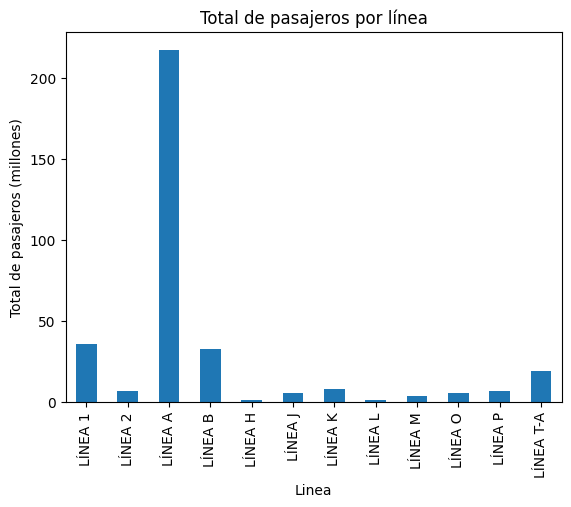

In [11]:
import matplotlib.ticker as ticker
ax = (df2023.groupby('Linea')['Total_pasajeros'].sum() / 1e6).plot(kind='bar')
plt.ylabel('Total de pasajeros (millones)')
plt.title('Total de pasajeros por línea')

ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.show()

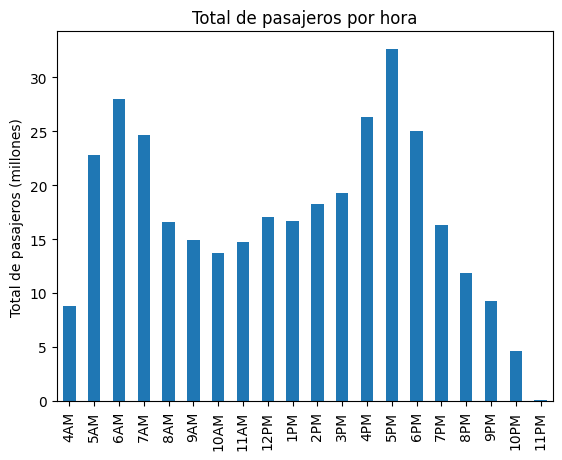

In [18]:
ax = (df2023.drop(columns=['Dia','Linea','Total_pasajeros']).sum()/ 1e6).plot(kind='bar')
plt.ylabel('Total de pasajeros (millones)')
plt.title('Total de pasajeros por hora')

ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.show() #agregar interact

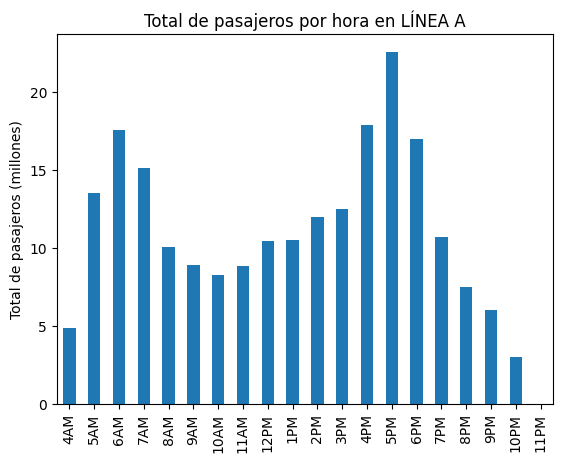

In [19]:
df_linea_a = df2023[df2023['Linea'] == 'LÍNEA A']

passengers_by_hour = (df_linea_a.drop(columns=['Dia', 'Linea', 'Total_pasajeros']).sum() / 1e6)

ax = passengers_by_hour.plot(kind='bar')
plt.ylabel('Total de pasajeros (millones)')
plt.title('Total de pasajeros por hora en LÍNEA A')

ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.show()

In [21]:
from ipywidgets import interact, Dropdown

#grafica interactiva
def update_plot(line):
    df_filtered = df2023[df2023['Linea'] == line]
    passengers_by_hour = (df_filtered.drop(columns=['Dia', 'Linea', 'Total_pasajeros']).sum() / 1e6)
    ax = passengers_by_hour.plot(kind='bar', figsize=(10, 5))
    plt.ylabel('Total de pasajeros (millones)')
    plt.title(f'Total de pasajeros por hora en {line}')
    ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    plt.show()

interact(update_plot, line=Dropdown(options=df2023['Linea'].unique(), value='LÍNEA A', description='Linea:'))


interactive(children=(Dropdown(description='Linea:', index=2, options=('LÍNEA 1', 'LÍNEA 2', 'LÍNEA A', 'LÍNEA…

<function __main__.update_plot(line)>

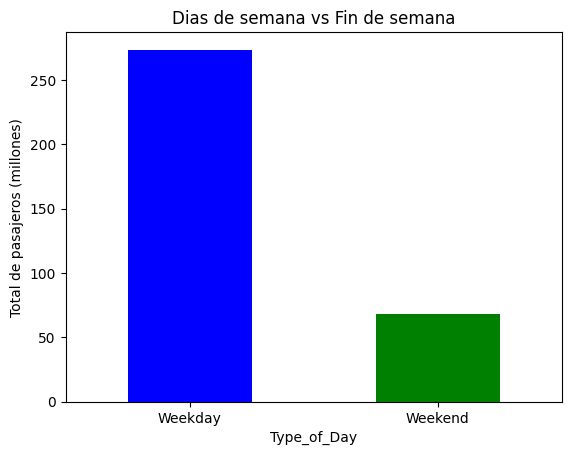

In [40]:
# Assuming df2023 is your DataFrame and 'Dia' is in "DD/MM/YYYY" format
# Convert 'Dia' column to datetime specifying the correct format
df2023['Dia'] = pd.to_datetime(df2023['Dia'], format='%d/%m/%Y')  # Note the format change

# Create a new column for the day of the week (0=Monday, 6=Sunday)
df2023['Dia_semana'] = df2023['Dia'].dt.dayofweek

# Classify as 'Weekday' or 'Weekend'
df2023['Tipo de dia'] = df2023['Day_of_Week'].apply(lambda x: 'Fin de semana' if x >= 5 else 'Entre semana')

# Aggregate passenger flow by Type_of_Day
passenger_summary = df2023.groupby('Tipo de dia')['Total_pasajeros'].sum()/ 1e6

# Plotting
ax = passenger_summary.plot(kind='bar', color=['blue', 'green'])
plt.ylabel('Total de pasajeros (millones)')
plt.title('Dias de semana vs Fin de semana')
plt.xticks(rotation=0)  # Rotate category labels for better readability
ax.get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.show()


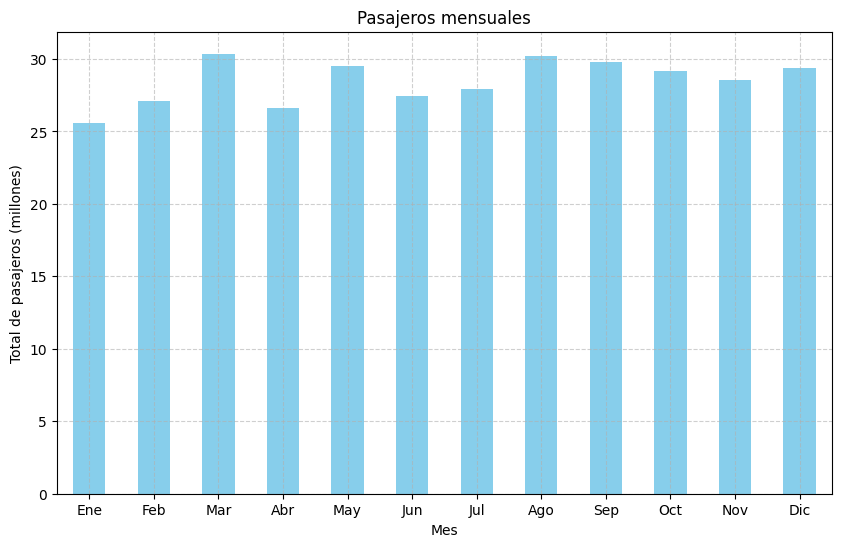

In [43]:


# Assuming df2023 is your DataFrame and it has a 'Total_pasajeros' and 'Dia' column
# Convert 'Dia' column to datetime if it's not already
df2023['Dia'] = pd.to_datetime(df2023['Dia'])

# Extract month from the Dia
df2023['Mes'] = df2023['Dia'].dt.month

# Aggregate passenger flow by month
monthly_passenger_flow = df2023.groupby('Mes')['Total_pasajeros'].sum()/1e6

# Plotting
plt.figure(figsize=(10, 6))
monthly_passenger_flow.plot(kind='bar', color='skyblue')
plt.title('Pasajeros mensuales')
plt.xlabel('Mes')
plt.ylabel('Total de pasajeros (millones)')
plt.xticks(ticks=range(len(monthly_passenger_flow)), labels=['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic'], rotation=0)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


In [23]:
df2019.head()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22
0,Día,Línea de servicio,Hora de operación,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,04:00:00,05:00:00,06:00:00,07:00:00,08:00:00,09:00:00,10:00:00,11:00:00,...,15:00:00,16:00:00,17:00:00,18:00:00,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00,Total general (Número de pasajeros)
2,2019-01-01 00:00:00,Línea 1,12,826,1134,987,884,975,1259,1348,...,2085,2230,2636,2884,2603,2024,1257,271,5,28850
3,2019-01-02 00:00:00,Línea 1,1716,4498,6629,6284,4145,3784,3746,3854,...,4709,5750,7517,6661,4307,2975,2709,1890,135,83484
4,2019-01-03 00:00:00,Línea 1,1860,4869,7587,7088,4483,4486,4126,4136,...,5061,6093,8023,7034,4481,3244,2905,1739,124,90472


In [22]:
df = pd.concat([df2019,df2020,df2021,df2022,df2024], axis=0) #Concatenamos los dataframes de 2020-2024 (me salte el 2023)
df.head() #mezclarlos bien pq quedaron horribles

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Día,Línea de Servicio,Hora de operación,Hora de Operación
0,Día,Línea de servicio,Hora de operación,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
1,NaN,NaN,04:00:00,05:00:00,06:00:00,07:00:00,08:00:00,09:00:00,10:00:00,11:00:00,...,19:00:00,20:00:00,21:00:00,22:00:00,23:00:00,Total general (Número de pasajeros),NaT,NaN,NaN,NaN
2,2019-01-01 00:00:00,Línea 1,12,826,1134,987,884,975,1259,1348,...,2603,2024,1257,271,5,28850,NaT,NaN,NaN,NaN
3,2019-01-02 00:00:00,Línea 1,1716,4498,6629,6284,4145,3784,3746,3854,...,4307,2975,2709,1890,135,83484,NaT,NaN,NaN,NaN
4,2019-01-03 00:00:00,Línea 1,1860,4869,7587,7088,4483,4486,4126,4136,...,4481,3244,2905,1739,124,90472,NaT,NaN,NaN,NaN


In [ ]:
df.to_excel('Afluencia2020-2024.xlsx')

In [ ]:
#Web scraping del clima 2023
import requests
from bs4 import BeautifulSoup

file = requests.get('https://www.wunderground.com/history/daily/co/olaya/SKMD/date/2023-4-2')
soup = BeautifulSoup(file.content, "html.parser")